In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import io

from interpretation.interpret import compute_importance_score_c_type, compute_importance_score_bias, visualize_sequence_imp
from models.models import CATAC_wo_bias, CATAC_w_bias

#Code form: https://stackoverflow.com/questions/57081727/load-pickle-file-obtained-from-gpu-to-cpu
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)

In [3]:
#Define function to plot training and testing losses
def plot_losses(paths_files, loss_name, model_name):
    
    with open(paths_files[0], 'rb') as file:
        train_loss = CPU_Unpickler(file).load()  
    train_loss = torch.stack(train_loss, dim=1)

    with open(paths_files[1], 'rb') as file:
        test_loss = CPU_Unpickler(file).load()
    test_loss = torch.stack(test_loss, dim=1)

    fig, ax = plt.subplots(nrows=2, ncols=2)

    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            col.plot(train_loss[(2*i)+j,:])
            col.plot(test_loss[(2*i)+j,:])
            col.set_title(time_point[(2*i)+j])
            col.set_xlabel('epoch')
            col.set_ylabel(loss_name)
    
    fig.suptitle(model_name)
    fig.tight_layout()
    plt.show()

    #Print average across head
    print("Train: ", np.mean([l[-1].item() for l in train_loss]))
    print("Test: ", np.mean([l[-1].item() for l in test_loss]))

In [4]:
#Define function to plot the evaluation metric
def plot_metric(path_file, metric_name, model_name):
    
    with open(path_file, 'rb') as file:
        metric = CPU_Unpickler(file).load()  

    metric = torch.stack(metric, dim=1)

    if metric_name == "jsd":
        metric = np.sqrt(metric)

    fig, ax = plt.subplots(nrows=2, ncols=2)

    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            col.plot(metric[(2*i)+j,:])
            col.set_title(time_point[(2*i)+j])
            col.set_xlabel('epoch')
            col.set_ylabel(metric_name)
    
    fig.suptitle(model_name)
    fig.tight_layout()
    plt.show()
        
    print(np.mean([l[-1].item() for l in metric]))


In [5]:
def plot_all_metrics(time_point, modelA_files, modelA_name, modelB_files, modelB_name):
    
    print("Total head losses")
    plot_losses([modelA_files[0]+ "train_MSE" + modelA_files[1], modelA_files[0]+ "test_MSE" + modelA_files[1]], "Total loss", modelA_name)
    plot_losses([modelB_files[0]+ "train_MSE" + modelB_files[1], modelB_files[0]+ "test_MSE" + modelB_files[1]], "Total loss", modelB_name)

    print("Correlation total prediction")
    plot_metric(modelA_files[0]+ "corr" + modelA_files[1], "corr", modelA_name)
    plot_metric(modelB_files[0]+ "corr" + modelB_files[1], "corr", modelB_name)

    print("Profile head losses")
    plot_losses([modelA_files[0]+ "train_KLD" + modelA_files[1], modelA_files[0]+ "test_KLD" + modelA_files[1]], "Profile loss", modelA_name)
    plot_losses([modelB_files[0]+ "train_KLD" + modelB_files[1], modelB_files[0]+ "test_KLD" + modelB_files[1]], "Profile loss", modelB_name)

    print("JSD profile prediction")
    plot_metric(modelA_files[0]+ "jsd" + modelA_files[1], "jsd", modelA_name)
    plot_metric(modelB_files[0]+ "jsd" + modelB_files[1], "jsd", modelB_name)

# Compare modelA vs modelB

In [11]:
import glob

save_file_type = ["train_KLD", "test_KLD", "jsd", "train_MSE", "test_MSE", "corr"]
time_point = ['D8', 'D12', 'D20', 'D22-15']

#Change here the prefix used too saved different models
modelA_files = ["../results/train_res/128_10_", ".pkl"]
modelA_name = "Final model"
modelB_files =  ["../results/train_res/1e-2_0.9_", ".pkl"]
modelB_name = "Optimized model"

In [1]:
#Plot the loss for each time point heads
plot_all_metrics(time_point, modelA_files, modelA_name, modelB_files, modelB_name)

NameError: name 'plot_all_metrics' is not defined

# Prepare figures
Plot average loss over prediction heads -> for the report

In [6]:
plt.rcParams.update({'font.size': 14})

#Define function to plot training and testing losses
def plot_average_losses(paths_files, loss_name, model_name):
    
    with open(paths_files[0], 'rb') as file:
        train_loss = CPU_Unpickler(file).load()  
    train_loss = torch.stack(train_loss, dim=1)
    train_loss = torch.mean(train_loss, dim=0)

    with open(paths_files[1], 'rb') as file:
        test_loss = CPU_Unpickler(file).load()
    test_loss = torch.stack(test_loss, dim=1)
    test_loss = torch.mean(test_loss, dim=0)

    if loss_name == "Total profile loss":
        train_loss/= 10; test_loss/= 10

    fig, ax = plt.subplots(nrows=1, ncols=1)

    ax.plot(train_loss, label='Training loss')
    ax.plot(test_loss, label ='Test loss')
    ax.set_xlabel('epoch')
    ax.set_ylabel(loss_name)
    fig.legend(loc="center right", bbox_to_anchor=(0, 0.5))

    fig.suptitle(model_name)
    fig.tight_layout()
    plt.show()

def plot_average_metrics(paths_files, metric_name, model_name):
    
    with open(paths_files, 'rb') as file:
        metric = CPU_Unpickler(file).load()  
    metric = torch.stack(metric, dim=1)
    metric = torch.mean(metric, dim=0)

    if metric_name == "JSD distance":
        metric = np.sqrt(metric)

    fig, ax = plt.subplots(nrows=1, ncols=1)

    ax.plot(metric)
    ax.set_xlabel('epoch')
    ax.set_ylabel(metric_name)
    fig.suptitle(model_name)
    fig.tight_layout()
    plt.show()

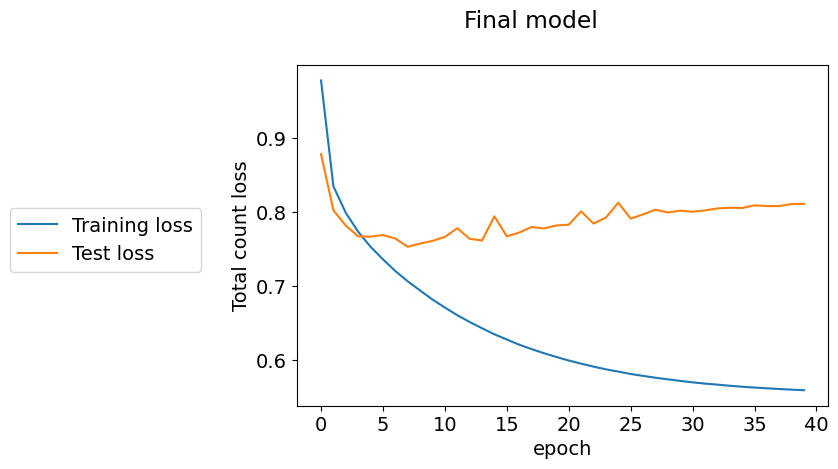

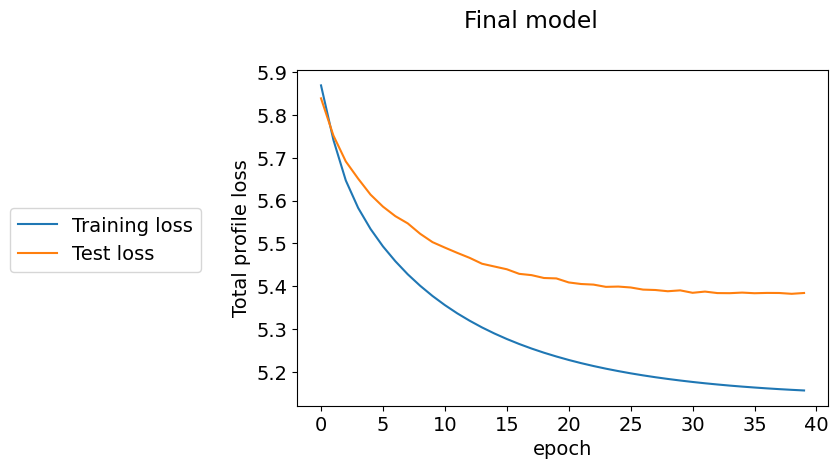

In [12]:
plot_average_losses([modelA_files[0]+ "train_MSE" + modelA_files[1], modelA_files[0]+ "test_MSE" + modelA_files[1]], "Total count loss", modelA_name)
plot_average_losses([modelA_files[0]+ "train_KLD" + modelA_files[1], modelA_files[0]+ "test_KLD" + modelA_files[1]], "Total profile loss", modelA_name)

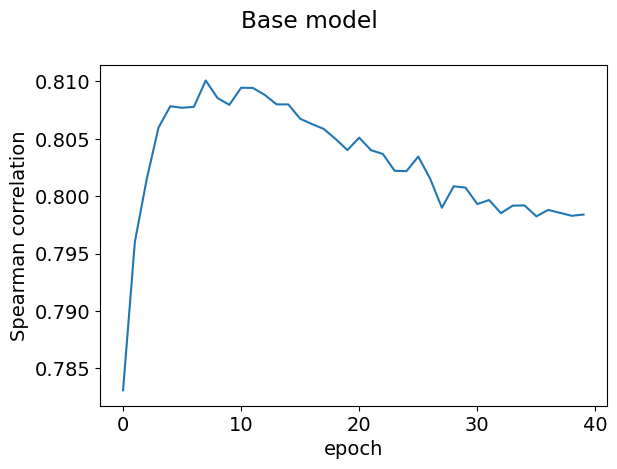

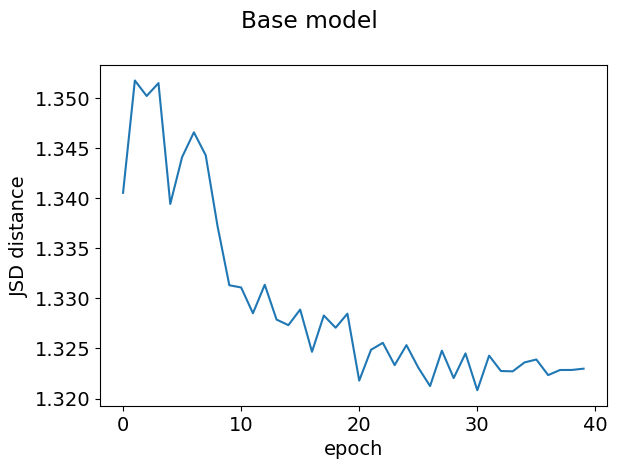

In [10]:
plot_average_metrics(modelA_files[0]+ "corr" + modelA_files[1], "Spearman correlation", modelA_name)
plot_average_metrics(modelA_files[0]+ "jsd" + modelA_files[1], "JSD distance", modelA_name)

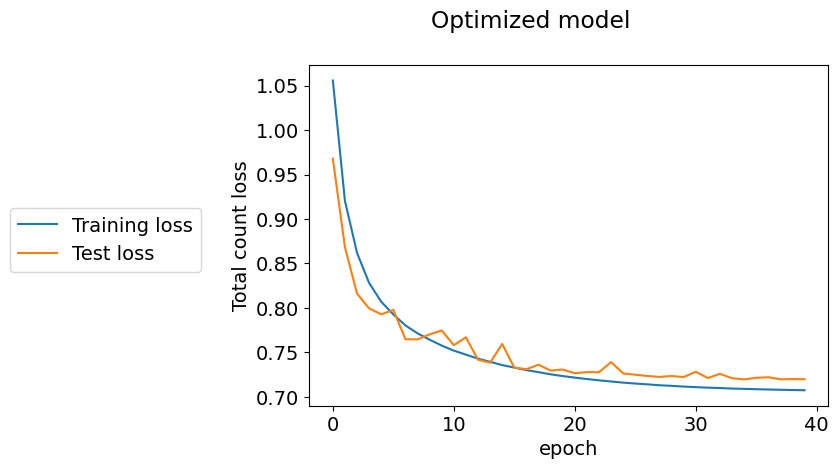

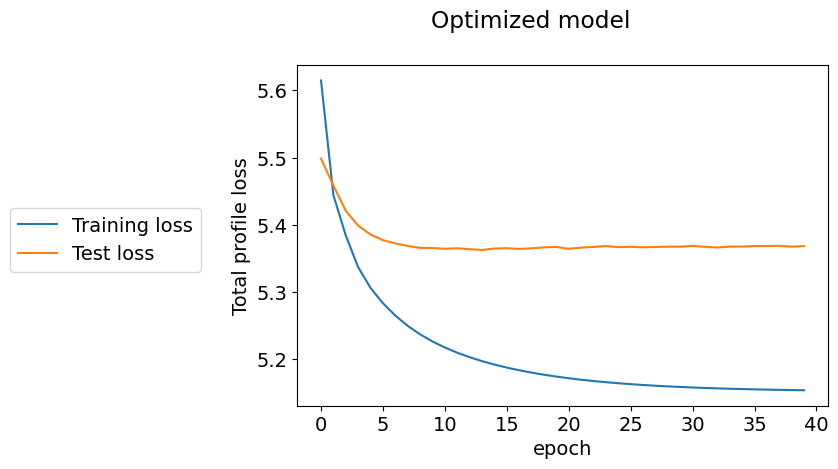

In [35]:
plot_average_losses([modelB_files[0]+ "train_MSE" + modelB_files[1], modelB_files[0]+ "test_MSE" + modelB_files[1]], "Total count loss", modelB_name)
plot_average_losses([modelB_files[0]+ "train_KLD" + modelB_files[1], modelB_files[0]+ "test_KLD" + modelB_files[1]], "Total profile loss", modelB_name)

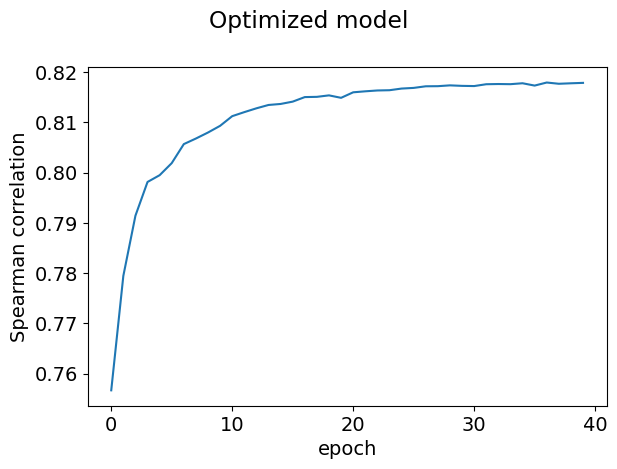

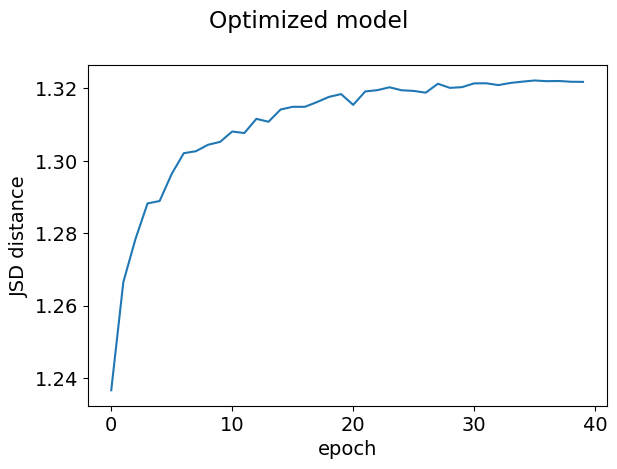

In [31]:
plot_average_metrics(modelB_files[0]+ "corr" + modelB_files[1], "Spearman correlation", modelB_name)
plot_average_metrics(modelB_files[0]+ "jsd" + modelB_files[1], "JSD distance", modelB_name)

# Evaluate final model variability

In [51]:
count_train_1 = ([0.32548221945762634, 0.529185950756073, 0.6132038831710815, 0.771053671836853])
count_test_1 = ([0.45600053668022156, 0.7855977416038513, 0.9056364297866821, 1.0985456705093384])
count_train_2 = ([0.331896036863327, 0.5437551736831665, 0.6254487037658691, 0.7827405333518982])
count_test_2  = ([0.4482119679450989, 0.770279586315155, 0.8860131502151489, 1.0761021375656128])
count_train_3 = ([0.32490047812461853, 0.524176299571991, 0.60443514585495, 0.7574669122695923])
count_test_3  = ([0.4589821994304657, 0.7921567559242249, 0.9096323847770691, 1.0996390581130981])
count_train = np.mean(np.array([count_train_1, count_train_2, count_train_3]), axis=0)
count_test = np.mean(np.array([count_test_1, count_test_2, count_test_3]), axis=0)


count_corr_1  = [0.8443615502602873, 0.8438996323778316, 0.7568653226619299, 0.7484657225556951]
count_corr_2  = [0.8465297972871264, 0.8462393150108203, 0.7613793200916539, 0.7535759735927833]
count_corr_3  = [0.8421015363095471, 0.8418088335389607, 0.755066067492164, 0.7475633000039352]
count_corr  = np.mean(np.array([count_corr_1, count_corr_2, count_corr_3]), axis=0)

profile_train_1 = [31.79853630065918, 56.92422866821289, 59.41600799560547, 58.099571228027344]
profile_test_1 = [33.920902252197266, 59.289581298828125, 61.520240783691406, 60.62602615356445]
profile_train_2 = [31.828189849853516, 56.99079513549805, 59.47743606567383, 58.17650604248047]
profile_test_2 = [33.95500564575195, 59.283355712890625, 61.52196502685547, 60.60369110107422]
profile_train_3 = [31.784107208251953, 56.928375244140625, 59.40918731689453, 58.1077766418457]
profile_test_3 = [33.945743560791016, 59.230812072753906, 61.465389251708984, 60.56386184692383]
profile_train  = np.mean(np.array([profile_train_1, profile_train_2, profile_train_3]), axis=0)
profile_test  = np.mean(np.array([profile_test_1, profile_test_2, profile_test_3]), axis=0)


jsd_1  = np.mean([1.3475782871246338, 1.2976077795028687, 1.316904902458191, 1.3293226957321167])
jsd_2  = np.mean([1.348049283027649, 1.2964587211608887, 1.3162099123001099, 1.3282274007797241])
jsd_3  = np.mean([1.3497601747512817, 1.297712802886963, 1.3174808025360107, 1.3294285535812378])
jsd  = np.mean(np.array([jsd_1, jsd_2, jsd_3]), axis=0)


df_performance = pd.DataFrame({'Train count loss': count_train,
                                'Test count loss': count_test,
                                'Spearman correlation': count_corr,
                                'Train profile loss': profile_train,
                                'Test profile loss': profile_test,
                                'Jensen-Shannon divergence distance': jsd}, index=['D8','D12','D20','D22'])

df_performance.loc['mean'] = df_performance.mean()
df_performance.loc['std'] = [0.009190, 0.010621, 0.002697, 0.003452, 0.002233, 0.000681]
df_performance

,Train count loss,Test count loss,Spearman correlation,Train profile loss,Test profile loss,Jensen-Shannon divergence distance
D8,0.327426,0.454398,0.844331,31.803611,33.940550,1.322895
D12,0.532372,0.782678,0.843983,56.947800,59.267916,1.322895
D20,0.614363,0.900427,0.757770,59.434210,61.502532,1.322895
D22,0.770420,1.091429,0.749868,58.127951,60.597860,1.322895
mean,0.561145,0.807233,0.798988,51.578393,53.827215,1.322895
std,0.009190,0.010621,0.002697,0.003452,0.002233,0.000681


In [56]:
print(df_performance.to_latex(

                  formatters={"name": str.upper},

                  float_format="{:.5f}".format,

))

\begin{tabular}{lrrrrrr}
\toprule
 & Train count loss & Test count loss & Spearman correlation & Train profile loss & Test profile loss & Jensen-Shannon divergence distance \\
\midrule
D8 & 0.32743 & 0.45440 & 0.84433 & 31.80361 & 33.94055 & 1.32290 \\
D12 & 0.53237 & 0.78268 & 0.84398 & 56.94780 & 59.26792 & 1.32290 \\
D20 & 0.61436 & 0.90043 & 0.75777 & 59.43421 & 61.50253 & 1.32290 \\
D22 & 0.77042 & 1.09143 & 0.74987 & 58.12795 & 60.59786 & 1.32290 \\
mean & 0.56115 & 0.80723 & 0.79899 & 51.57839 & 53.82721 & 1.32290 \\
std & 0.00919 & 0.01062 & 0.00270 & 0.00345 & 0.00223 & 0.00068 \\
\bottomrule
\end{tabular}

